# prepare

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Other setting
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhechensu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'gmail', 'cscl', 'edu', 'use', 'et_al'])

In [3]:
def parse(file_path): 
    i = 0 
    tmp = ''
    key = ''
    xml2 =etree.iterparse(file_path, recover=True)
    data = []
    for action, elem in xml2:
        data.append((elem.attrib,elem.text))
    data_dict = {}
    l = set()
    for elem in data: 
        try : 
            tmp = key 
            key = elem[0].get('qualifier')
            if key == 'author':
                l.add(elem[1])
                data_dict[key] = l
                if tmp == key:
                    l.add(elem[1])
                    data_dict[key] = l
                else : 
                    l = set()
            else : 
                data_dict[key] = elem[1]
        except TypeError: 
                data_dict['None'] = elem[1]
    return data_dict

In [4]:
import os
rootdir = 'data/papers'
contents = []
i = 0
num_2014 = 0
num_2015 = 0
num_2016 = 0
num_2017 = 0
num_2018 = 0
source = []
errors = []
docid = dict()
for subdir, dirs, files in os.walk(rootdir):
    files.sort()
    for file in files:
        if 'txt' in file:
            if '2014' in file:
                num_2014 += 1
            if '2015' in file:
                num_2015 += 1
            if '2016' in file:
                num_2016 += 1
            if '2017' in file:
                num_2017 += 1
            if '2018' in file:
                num_2018 += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    docid[i] = [file.name.split('/')[-1].split('.')[0]]
                    source.append(subdir[len(rootdir):])
                    i = i+1
                except:
                    name, message, content = sys.exc_info()
                    errors.append(message)


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(contents))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

import spacy
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization_(data_words_bigrams)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


# set word filter

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_below=30, no_above=0.4)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [8]:
# os.environ.update({'MALLET_HOME':'/Users/zhenchensu/Documents/GitHub/semester-project/mallet'})
mallet_path = './mallet/bin/mallet' 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=70, step=1)


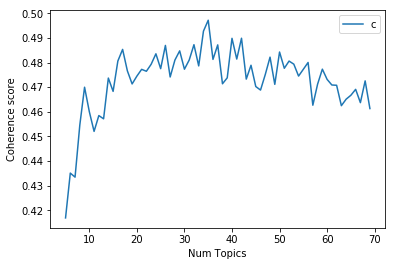

In [11]:
# Show graph
limit=70; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
# Print the coherence scores
i =0
for m, cv in zip(x, coherence_values):
    print("Index = ",i,"Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i = i+1


Index =  0 Num Topics = 5  has Coherence Value of 0.4169
Index =  1 Num Topics = 6  has Coherence Value of 0.4351
Index =  2 Num Topics = 7  has Coherence Value of 0.4335
Index =  3 Num Topics = 8  has Coherence Value of 0.4546
Index =  4 Num Topics = 9  has Coherence Value of 0.47
Index =  5 Num Topics = 10  has Coherence Value of 0.46
Index =  6 Num Topics = 11  has Coherence Value of 0.452
Index =  7 Num Topics = 12  has Coherence Value of 0.4584
Index =  8 Num Topics = 13  has Coherence Value of 0.4571
Index =  9 Num Topics = 14  has Coherence Value of 0.4737
Index =  10 Num Topics = 15  has Coherence Value of 0.4683
Index =  11 Num Topics = 16  has Coherence Value of 0.4806
Index =  12 Num Topics = 17  has Coherence Value of 0.4853
Index =  13 Num Topics = 18  has Coherence Value of 0.4766
Index =  14 Num Topics = 19  has Coherence Value of 0.4713
Index =  15 Num Topics = 20  has Coherence Value of 0.4745
Index =  16 Num Topics = 21  has Coherence Value of 0.4772
Index =  17 Num T

# plot
The key is to find a topic number which can express a topic in adequate scale(a range around a number). The approach to find it is checking keywords in each topic and if they seem like mixing two TRUE topic, the topic number we choose is small. On the contrary, if we find some non sense topic like all keywords are normal and meaningless words, the topic number is too large.

In [13]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.059975 -0.054658       1        1  16.779331
6     -0.071915 -0.078254       2        1  14.441386
4      0.013802 -0.041207       3        1  13.675436
7     -0.226775 -0.001985       4        1  12.309623
1      0.227077 -0.052701       5        1  12.168370
8      0.076672 -0.091546       6        1  11.042811
2     -0.168210 -0.031572       7        1  10.187669
0      0.063259  0.060687       8        1   5.142302
3      0.026115  0.291237       9        1   4.253068, topic_info=     Category         Freq           Term        Total  loglift  logprob
527   Default  3205.000000           game  3205.000000  30.0000  30.0000
747   Default  3699.000000      condition  3699.000000  29.0000  29.0000
392   Default  3052.000000           text  3052.000000  28.0000  28.0000
711   Default  2440.000000          youth  2440.000000  27.0000  27.0000
801   Default  1831.000000        gesture  1831.000000  26.0000  26.0000
1538  Default  2048.000000           stem  2048.000000  25.0000  25.0000
1471  Default  1410.000000    engineering  1410.000000  24.0000  24.0000
2424  Default  2327.000000    facilitator  2327.000000  23.0000  23.0000
584   Default  1732.000000     mathematic  1732.000000  22.0000  22.0000
787   Default  1612.000000         family  1612.000000  21.0000  21.0000
1012  Default  2450.000000       feedback  2450.000000  20.0000  20.0000
1786  Default  1476.000000    progression  1476.000000  19.0000  19.0000
1035  Default  1221.000000   mathematical  1221.000000  18.0000  18.0000
689   Default  3275.000000           team  3275.000000  17.0000  17.0000
157   Default  1442.000000         expert  1442.000000  16.0000  16.0000
326   Default  2463.000000           read  2463.000000  15.0000  15.0000
550   Default  1628.000000       identity  1628.000000  14.0000  14.0000
455   Default  1592.000000           code  1592.000000  13.0000  13.0000
267   Default  2421.000000        network  2421.000000  12.0000  12.0000
1433  Default  1141.000000       workshop  1141.000000  11.0000  11.0000
773   Default  1378.000000         energy  1378.000000  10.0000  10.0000
1844  Default  1073.000000     instructor  1073.000000   9.0000   9.0000
350   Default  2027.000000          score  2027.000000   8.0000   8.0000
39    Default  1995.000000       behavior  1995.000000   7.0000   7.0000
230   Default  1644.000000         lesson  1644.000000   6.0000   6.0000
1338  Default  1655.000000      epistemic  1655.000000   5.0000   5.0000
632   Default   761.000000    programming   761.000000   4.0000   4.0000
607   Default  1144.000000         parent  1144.000000   3.0000   3.0000
75    Default   781.000000  computational   781.000000   2.0000   2.0000
1414  Default  1899.000000     simulation  1899.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2462   Topic9    42.413643           wing    56.693459   2.8673  -6.7132
1035   Topic9   880.861816   mathematical  1221.427734   2.8307  -3.6798
2991   Topic9    63.872120           clip    90.159027   2.8128  -6.3038
2050   Topic9    45.808784        command    66.088379   2.7910  -6.6362
2579   Topic9    93.865486      summative   135.982788   2.7869  -5.9188
2466   Topic9    55.075542      blikstein    83.431625   2.7422  -6.4520
1433   Topic9   742.350891       workshop  1141.088989   2.7276  -3.8509
2774   Topic9    98.422112      invention   155.283173   2.7015  -5.8714
2433   Topic9    99.847610          kafai   159.863495   2.6869  -5.8570
465    Topic9   430.976868        compute   704.076538   2.6667  -4.3946
2486   Topic9    83.388985           loop   141.875183   2.6261  -6.0372
1745   Topic9   105.152596           echo   180.859833   2.6152  -5.8053
801    Topic9  1053.967896        gesture  1831.150757   2.6051  -3.5004
584    Topic9   985.457764     mathematic  1732.555908   2.5933  -3.5676
2643 

In [14]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=17, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.003681  0.019043       1        1  14.417812
9      0.152151  0.085895       2        1  11.089647
7     -0.179697  0.043739       3        1   8.986557
4      0.027538  0.065192       4        1   8.319397
13     0.124068 -0.005376       5        1   7.567386
2     -0.197145 -0.041507       6        1   6.997364
8      0.033052  0.113508       7        1   6.144948
5     -0.099375 -0.042309       8        1   5.271210
6     -0.096556 -0.000170       9        1   5.146416
11    -0.126334  0.083599      10        1   4.938764
12     0.091510  0.204703      11        1   4.171361
16    -0.080514 -0.022564      12        1   3.689816
3     -0.036419  0.069589      13        1   3.277069
1      0.241169 -0.098834      14        1   3.241090
0      0.073555 -0.031586      15        1   2.730023
15    -0.057540 -0.290632      16        1   2.113617
14     0.134218 -0.152290      17        1   1.897524, topic_info=     Category         Freq               Term        Total  loglift  logprob
527   Default  3157.000000               game  3157.000000  30.0000  30.0000
392   Default  2236.000000               text  2236.000000  29.0000  29.0000
711   Default  2407.000000              youth  2407.000000  28.0000  28.0000
747   Default  3704.000000          condition  3704.000000  27.0000  27.0000
326   Default  1967.000000               read  1967.000000  26.0000  26.0000
230   Default  1950.000000             lesson  1950.000000  25.0000  25.0000
773   Default  1973.000000             energy  1973.000000  24.0000  24.0000
1012  Default  2782.000000           feedback  2782.000000  23.0000  23.0000
801   Default  1633.000000            gesture  1633.000000  22.0000  22.0000
689   Default  2953.000000               team  2953.000000  21.0000  21.0000
267   Default  2990.000000            network  2990.000000  20.0000  20.0000
1538  Default  2008.000000               stem  2008.000000  19.0000  19.0000
1414  Default  2012.000000         simulation  2012.000000  18.0000  18.0000
1471  Default  1349.000000        engineering  1349.000000  17.0000  17.0000
584   Default  1750.000000         mathematic  1750.000000  16.0000  16.0000
2424  Default  1811.000000        facilitator  1811.000000  15.0000  15.0000
550   Default  1884.000000           identity  1884.000000  14.0000  14.0000
1035  Default  1168.000000       mathematical  1168.000000  13.0000  13.0000
157   Default  1304.000000             expert  1304.000000  12.0000  12.0000
1786  Default  1361.000000        progression  1361.000000  11.0000  11.0000
645   Default  1958.000000         reflection  1958.000000  10.0000  10.0000
1031  Default  1420.000000              light  1420.000000   9.0000   9.0000
1844  Default  1017.000000         instructor  1017.000000   8.0000   8.0000
656   Default  1914.000000              scale  1914.000000   7.0000   7.0000
490   Default  1329.000000            digital  1329.000000   6.0000   6.0000
459   Default  1223.000000            comment  1223.000000   5.0000   5.0000
799   Default   965.000000               gaze   965.000000   4.0000   4.0000
455   Default  1645.000000               code  1645.000000   3.0000   3.0000
1226  Default  1788.000000           physical  1788.000000   2.0000   2.0000
1433  Default  1220.000000           workshop  1220.000000   1.0000   1.0000
...       ...          ...                ...          ...      ...      ...
180   Topic17    35.627071              genre    76.980713   3.1942  -6.0805
2183  Topic17    42.166790  augmented_reality    97.848778   3.1228  -5.9120
1500  Topic17    20.080809            mission    47.139832   3.1113  -6.6538
1792  Topic17   347.566742               rule   821.676392   3.1042  -3.8026
451   Topic17   178.830276          character   422.798492   3.1042  -4.4671
679   Topic17   371.789124              story   929.999390   3.0478  -3.7353
2124 

In [15]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.018836  0.110255       1        1  12.394726
9      0.199087  0.021784       2        1   9.033568
17    -0.066524 -0.055834       3        1   8.702982
7     -0.215811  0.028154       4        1   7.385244
4      0.036740  0.106155       5        1   7.085212
2     -0.142086 -0.020969       6        1   6.732173
8      0.049766  0.040527       7        1   6.722246
19     0.130618  0.013718       8        1   5.866168
10     0.090638  0.018702       9        1   5.628306
13     0.163220 -0.060339      10        1   5.165101
18     0.108682 -0.098615      11        1   4.319564
11    -0.143780  0.146011      12        1   3.090925
12     0.045187  0.189696      13        1   2.891792
16    -0.183993 -0.081287      14        1   2.682809
0      0.033292 -0.023108      15        1   2.628435
3     -0.036325  0.221015      16        1   2.551914
1      0.077314 -0.220991      17        1   2.128753
5     -0.175959 -0.155073      18        1   1.798770
14     0.067938 -0.080357      19        1   1.733712
15    -0.056839 -0.099444      20        1   1.457599, topic_info=     Category         Freq            Term        Total  loglift  logprob
527   Default  3072.000000            game  3072.000000  30.0000  30.0000
1012  Default  2716.000000        feedback  2716.000000  29.0000  29.0000
392   Default  2113.000000            text  2113.000000  28.0000  28.0000
747   Default  3728.000000       condition  3728.000000  27.0000  27.0000
326   Default  1849.000000            read  1849.000000  26.0000  26.0000
801   Default  1913.000000         gesture  1913.000000  25.0000  25.0000
773   Default  1944.000000          energy  1944.000000  24.0000  24.0000
1538  Default  1792.000000            stem  1792.000000  23.0000  23.0000
584   Default  1905.000000      mathematic  1905.000000  22.0000  22.0000
1035  Default  1379.000000    mathematical  1379.000000  21.0000  21.0000
689   Default  3174.000000            team  3174.000000  20.0000  20.0000
1414  Default  1952.000000      simulation  1952.000000  19.0000  19.0000
711   Default  2238.000000           youth  2238.000000  18.0000  18.0000
550   Default  1823.000000        identity  1823.000000  17.0000  17.0000
657   Default  1451.000000       scientist  1451.000000  16.0000  16.0000
1471  Default  1146.000000     engineering  1146.000000  15.0000  15.0000
459   Default  1187.000000         comment  1187.000000  14.0000  14.0000
2424  Default  1808.000000     facilitator  1808.000000  13.0000  13.0000
1338  Default  1702.000000       epistemic  1702.000000  12.0000  12.0000
267   Default  1918.000000         network  1918.000000  11.0000  11.0000
645   Default  2030.000000      reflection  2030.000000  10.0000  10.0000
455   Default  1580.000000            code  1580.000000   9.0000   9.0000
687   Default  1147.000000          survey  1147.000000   8.0000   8.0000
1786  Default  1361.000000     progression  1361.000000   7.0000   7.0000
1031  Default  1368.000000           light  1368.000000   6.0000   6.0000
787   Default  1194.000000          family  1194.000000   5.0000   5.0000
350   Default  2061.000000           score  2061.000000   4.0000   4.0000
230   Default  1487.000000          lesson  1487.000000   3.0000   3.0000
1433  Default  1287.000000        workshop  1287.000000   2.0000   2.0000
881   Default  2254.000000         quality  2254.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
3124  Topic20    37.493031           lemke    75.810928   3.5243  -5.7657
2509  Topic20    32.565601            tail    66.392075   3.5161  -5.9066
1644  Topic20   256.476318            mode   553.808472   3.4586  -3.8428
1109  Topic20    11.521687           wiley    25.524513   3.4330  -6.9456
235   Topic20   488.289642        literacy  1102.269165   3.4142  -3.1989
1148  Topic20    25.274782     

In [16]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=24, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.062217 -0.104103       1        1  9.876187
13     0.201580  0.017850       2        1  9.804996
9      0.155243  0.010705       3        1  9.431123
7     -0.090456 -0.168104       4        1  8.138695
4      0.060822 -0.032658       5        1  8.079393
10     0.046715 -0.104637       6        1  6.917976
8      0.058031  0.001902       7        1  5.651857
23     0.160017  0.032659       8        1  4.357198
5     -0.056297 -0.146151       9        1  3.836295
20     0.120500 -0.013600      10        1  3.662140
21     0.046586 -0.023024      11        1  3.629702
6     -0.060142 -0.063484      12        1  3.339130
19     0.206636  0.099633      13        1  3.064845
18     0.135116  0.025941      14        1  2.829385
2     -0.173762 -0.140560      15        1  2.734595
11    -0.097195 -0.126963      16        1  2.693687
22    -0.075864  0.082750      17        1  2.279503
3      0.018893 -0.048180      18        1  1.953936
0     -0.122897  0.035622      19        1  1.587693
14    -0.031779  0.161128      20        1  1.550690
15    -0.099781  0.096256      21        1  1.457266
16    -0.152082 -0.046084      22        1  1.408799
12    -0.086519  0.279374      23        1  0.900764
1     -0.225582  0.173726      24        1  0.814144, topic_info=     Category         Freq           Term        Total  loglift  logprob
527   Default  3322.000000           game  3322.000000  30.0000  30.0000
1012  Default  2753.000000       feedback  2753.000000  29.0000  29.0000
747   Default  4154.000000      condition  4154.000000  28.0000  28.0000
392   Default  2096.000000           text  2096.000000  27.0000  27.0000
773   Default  1611.000000         energy  1611.000000  26.0000  26.0000
326   Default  1860.000000           read  1860.000000  25.0000  25.0000
267   Default  2331.000000        network  2331.000000  24.0000  24.0000
711   Default  2019.000000          youth  2019.000000  23.0000  23.0000
645   Default  1930.000000     reflection  1930.000000  22.0000  22.0000
2424  Default  1953.000000    facilitator  1953.000000  21.0000  21.0000
801   Default  1574.000000        gesture  1574.000000  20.0000  20.0000
1414  Default  1587.000000     simulation  1587.000000  19.0000  19.0000
689   Default  3341.000000           team  3341.000000  18.0000  18.0000
722   Default  1304.000000  argumentation  1304.000000  17.0000  17.0000
550   Default  1618.000000       identity  1618.000000  16.0000  16.0000
26    Default  1482.000000       argument  1482.000000  15.0000  15.0000
1226  Default  1675.000000       physical  1675.000000  14.0000  14.0000
777   Default  1035.000000        episode  1035.000000  13.0000  13.0000
1786  Default  1505.000000    progression  1505.000000  12.0000  12.0000
230   Default  1433.000000         lesson  1433.000000  11.0000  11.0000
1538  Default  1804.000000           stem  1804.000000  10.0000  10.0000
584   Default  1916.000000     mathematic  1916.000000   9.0000   9.0000
350   Default  2176.000000          score  2176.000000   8.0000   8.0000
787   Default  1314.000000         family  1314.000000   7.0000   7.0000
410   Default  2081.000000           unit  2081.000000   6.0000   6.0000
157   Default  1521.000000         expert  1521.000000   5.0000   5.0000
401   Default   930.000000       transfer   930.000000   4.0000   4.0000
1471  Default  1469.000000    engineering  1469.000000   3.0000   3.0000
367   Default  1745.000000       solution  1745.000000   2.0000   2.0000
455   Default  1582.000000           code  1582.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
648   Topic24   194.283829         revise   579.963745   3.7171  -3.5381
1741  Topic24    18.288086      diagnosis    67.148621   3.5101  -5.9012
2043  Topic24    63.560688       automate   252.735840   3.4304  -4.6554
2056  Topic24   128.7566

In [17]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=29, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.158290 -0.069330       1        1  9.020984
2      0.061936  0.167536       2        1  8.829517
9      0.145245 -0.040221       3        1  8.184824
4      0.083207  0.014344       4        1  6.672911
26     0.117008 -0.039052       5        1  6.011989
7     -0.020685  0.216623       6        1  5.652480
8      0.071192  0.037760       7        1  4.917059
17     0.080171  0.091856       8        1  4.735878
25     0.112123 -0.233643       9        1  4.710890
21     0.070641  0.111553      10        1  4.080447
19     0.084789 -0.024723      11        1  3.816999
6      0.035985  0.118544      12        1  3.657467
14     0.058693  0.022161      13        1  3.470100
23     0.109450 -0.171126      14        1  3.387548
20     0.095408 -0.026104      15        1  2.799578
13     0.064952 -0.129617      16        1  2.512658
24     0.069549 -0.072181      17        1  2.317829
11    -0.007055  0.146056      18        1  2.041402
16    -0.049334  0.147276      19        1  1.889420
22    -0.122825  0.045088      20        1  1.871780
27    -0.084578 -0.046368      21        1  1.680278
0     -0.041134  0.104721      22        1  1.587370
3     -0.052390  0.066306      23        1  1.528435
15    -0.107281 -0.014281      24        1  1.340169
18    -0.066995 -0.134850      25        1  1.064495
5     -0.107248 -0.055642      26        1  0.722135
1     -0.230394 -0.172630      27        1  0.683133
28    -0.240015 -0.045216      28        1  0.548060
12    -0.288703 -0.014838      29        1  0.264167, topic_info=     Category         Freq             Term        Total  loglift  logprob
527   Default  3521.000000             game  3521.000000  30.0000  30.0000
689   Default  2694.000000             team  2694.000000  29.0000  29.0000
747   Default  3715.000000        condition  3715.000000  28.0000  28.0000
392   Default  2127.000000             text  2127.000000  27.0000  27.0000
267   Default  2022.000000          network  2022.000000  26.0000  26.0000
801   Default  1924.000000          gesture  1924.000000  25.0000  25.0000
1012  Default  2342.000000         feedback  2342.000000  24.0000  24.0000
326   Default  1864.000000             read  1864.000000  23.0000  23.0000
490   Default  1656.000000          digital  1656.000000  22.0000  22.0000
584   Default  1901.000000       mathematic  1901.000000  21.0000  21.0000
1786  Default   996.000000      progression   996.000000  20.0000  20.0000
1414  Default  1595.000000       simulation  1595.000000  19.0000  19.0000
2424  Default  1773.000000      facilitator  1773.000000  18.0000  18.0000
1035  Default  1387.000000     mathematical  1387.000000  17.0000  17.0000
711   Default  2300.000000            youth  2300.000000  16.0000  16.0000
1026  Default  1253.000000             item  1253.000000  15.0000  15.0000
230   Default  1574.000000           lesson  1574.000000  14.0000  14.0000
26    Default  1519.000000         argument  1519.000000  13.0000  13.0000
1289  Default  1130.000000             user  1130.000000  12.0000  12.0000
773   Default   989.000000           energy   989.000000  11.0000  11.0000
722   Default  1225.000000    argumentation  1225.000000  10.0000  10.0000
550   Default  1706.000000         identity  1706.000000   9.0000   9.0000
314   Default  1701.000000     problem_solv  1701.000000   8.0000   8.0000
350   Default  2059.000000            score  2059.000000   7.0000   7.0000
645   Default  1927.000000       reflection  1927.000000   6.0000   6.0000
343   Default  1744.000000   representation  1744.000000   5.0000   5.0000
1226  Default  1708.000000         physical  1708.000000   4.0000   4.0000
367   Default  1644.000000         solution  1644.000000   3.0000   3.0000
787   Default  1212.000000           family  1212.000000   2.0000   2.0000
1538  Default  1612.000000             stem  1612.000000   1.000

In [18]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=32, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.096606 -0.115453       1        1  7.841000
13     0.196325  0.080320       2        1  6.612721
4      0.064325 -0.067676       3        1  6.338061
8      0.062334 -0.060539       4        1  6.123486
7     -0.083597 -0.205831       5        1  5.806807
9      0.206117  0.077314       6        1  5.736563
2     -0.034814 -0.212740       7        1  5.679492
14     0.088263 -0.047245       8        1  5.250780
17     0.113642 -0.068589       9        1  4.868283
10     0.165464  0.015632      10        1  4.858002
26     0.083202 -0.127907      11        1  4.147386
21     0.042290 -0.093169      12        1  4.094697
23     0.144213  0.066546      13        1  3.257219
20     0.105673  0.013062      14        1  3.133455
19     0.083582  0.040403      15        1  3.129596
6     -0.051421 -0.105396      16        1  2.286211
31     0.002994 -0.012307      17        1  2.270699
22    -0.160480 -0.015634      18        1  1.899364
18     0.082308  0.115123      19        1  1.781418
24     0.017843  0.154923      20        1  1.701022
11    -0.096719 -0.144749      21        1  1.653840
15    -0.075504  0.019446      22        1  1.622620
27    -0.031089 -0.004222      23        1  1.595468
3     -0.105984 -0.040125      24        1  1.472159
16    -0.110999 -0.027043      25        1  1.425860
30    -0.182219 -0.001900      26        1  1.267224
0     -0.182401  0.065879      27        1  1.098967
29    -0.137498  0.091839      28        1  1.021168
25     0.036837  0.237425      29        1  0.879854
28    -0.087654  0.118662      30        1  0.830023
12    -0.220346  0.177624      31        1  0.261115
1     -0.031293  0.076329      32        1  0.055445, topic_info=     Category         Freq              Term        Total  loglift  logprob
689   Default  3291.000000              team  3291.000000  30.0000  30.0000
527   Default  2600.000000              game  2600.000000  29.0000  29.0000
747   Default  3776.000000         condition  3776.000000  28.0000  28.0000
392   Default  2189.000000              text  2189.000000  27.0000  27.0000
267   Default  2647.000000           network  2647.000000  26.0000  26.0000
1012  Default  2779.000000          feedback  2779.000000  25.0000  25.0000
801   Default  1886.000000           gesture  1886.000000  24.0000  24.0000
550   Default  1930.000000          identity  1930.000000  23.0000  23.0000
773   Default  1610.000000            energy  1610.000000  22.0000  22.0000
584   Default  1852.000000        mathematic  1852.000000  21.0000  21.0000
1786  Default  1038.000000       progression  1038.000000  20.0000  20.0000
794   Default  1434.000000             frame  1434.000000  19.0000  19.0000
326   Default  1927.000000              read  1927.000000  18.0000  18.0000
314   Default  1595.000000      problem_solv  1595.000000  17.0000  17.0000
2424  Default  1841.000000       facilitator  1841.000000  16.0000  16.0000
1414  Default  1555.000000        simulation  1555.000000  15.0000  15.0000
367   Default  1525.000000          solution  1525.000000  14.0000  14.0000
1035  Default  1348.000000      mathematical  1348.000000  13.0000  13.0000
1371  Default  1235.000000               map  1235.000000  12.0000  12.0000
711   Default  2257.000000             youth  2257.000000  11.0000  11.0000
1329  Default  1740.000000      disciplinary  1740.000000  10.0000  10.0000
645   Default  1943.000000        reflection  1943.000000   9.0000   9.0000
657   Default  1493.000000         scientist  1493.000000   8.0000   8.0000
610   Default  1241.000000           partner  1241.000000   7.0000   7.0000
343   Default  1907.000000    representation  1907.000000   6.0000   6.0000
1338  Default  1742.000000         epistemic  1742.000000   5.0000   5.0000
1226  Default  1630.000000          physical  1630.000000   4.0000   4.0000
903   Default  1998.000000 

In [19]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=35, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.132628  0.062363       1        1  8.891521
34     0.079150  0.033155       2        1  7.199059
7     -0.033401  0.217951       3        1  6.214189
4      0.099501 -0.000374       4        1  5.566287
9      0.153465 -0.125172       5        1  5.254174
2      0.018571  0.220412       6        1  5.133092
14     0.100836 -0.008530       7        1  4.844644
8      0.058801 -0.042690       8        1  4.811976
13     0.143731 -0.172973       9        1  4.672917
26     0.101897  0.026965      10        1  4.643725
17     0.017471  0.152120      11        1  3.496433
11    -0.030912  0.129511      12        1  3.401283
23     0.100694 -0.115106      13        1  3.396668
19     0.038832 -0.051614      14        1  2.960894
20     0.034184 -0.072839      15        1  2.768386
21     0.013409  0.053009      16        1  2.750115
10     0.073841 -0.019382      17        1  2.747629
0     -0.128271  0.099521      18        1  2.018287
32     0.066676 -0.090512      19        1  1.970118
24    -0.042711 -0.119494      20        1  1.726798
16    -0.150674  0.105914      21        1  1.567369
22    -0.189034 -0.056670      22        1  1.564987
31    -0.074299 -0.111628      23        1  1.526295
3     -0.087425  0.008506      24        1  1.503667
5     -0.137522  0.067447      25        1  1.462243
27    -0.103245 -0.047681      26        1  1.404448
25    -0.058094 -0.252779      27        1  1.383307
29    -0.139854 -0.045848      28        1  1.329314
15    -0.136332  0.045328      29        1  1.126381
28    -0.163396 -0.112220      30        1  1.026217
30    -0.194887 -0.051089      31        1  0.967106
18    -0.166024  0.074660      32        1  0.661799
1      0.197189  0.067260      33        1  0.007244
33     0.202604  0.066239      34        1  0.000718
12     0.202604  0.066239      35        1  0.000709, topic_info=     Category         Freq            Term        Total  loglift  logprob
527   Default  3114.000000            game  3114.000000  30.0000   30.000
689   Default  3078.000000            team  3078.000000  29.0000   29.000
1012  Default  2787.000000        feedback  2787.000000  28.0000   28.000
711   Default  2346.000000           youth  2346.000000  27.0000   27.000
392   Default  2046.000000            text  2046.000000  26.0000   26.000
747   Default  3751.000000       condition  3751.000000  25.0000   25.000
267   Default  2281.000000         network  2281.000000  24.0000   24.000
584   Default  2089.000000      mathematic  2089.000000  23.0000   23.000
326   Default  1760.000000            read  1760.000000  22.0000   22.000
1035  Default  1587.000000    mathematical  1587.000000  21.0000   21.000
801   Default  1536.000000         gesture  1536.000000  20.0000   20.000
1371  Default  1259.000000             map  1259.000000  19.0000   19.000
1338  Default  1907.000000       epistemic  1907.000000  18.0000   18.000
2424  Default  1651.000000     facilitator  1651.000000  17.0000   17.000
881   Default  2283.000000         quality  2283.000000  16.0000   16.000
343   Default  1806.000000  representation  1806.000000  15.0000   15.000
230   Default  1472.000000          lesson  1472.000000  14.0000   14.000
1414  Default  1619.000000      simulation  1619.000000  13.0000   13.000
550   Default  1708.000000        identity  1708.000000  12.0000   12.000
1245  Default  1855.000000       reasoning  1855.000000  11.0000   11.000
1226  Default  1575.000000        physical  1575.000000  10.0000   10.000
1471  Default  1375.000000     engineering  1375.000000   9.0000    9.000
26    Default  1639.000000        argument  1639.000000   8.0000    8.000
314   Default  1590.000000    problem_solv  1590.000000   7.0000    7.000
2113  Default  1065.000000           tutor  1065.000000   6.0000    6.000
645   Default  1831.000000      reflection  1831.000000   5.0000    5.00

In [20]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
37    -0.152383  0.031550       1        1  7.871879
9     -0.144375  0.130661       2        1  6.522396
2     -0.123281 -0.176994       3        1  6.115190
34    -0.099100  0.008691       4        1  5.659440
23    -0.137571  0.131663       5        1  5.598075
4     -0.115646 -0.000937       6        1  5.265214
7     -0.066746 -0.220876       7        1  5.174732
35    -0.059670 -0.176233       8        1  4.433596
26    -0.115252  0.020234       9        1  4.418980
11    -0.043047 -0.139052      10        1  4.171770
36    -0.068798  0.052918      11        1  4.110831
21    -0.075952 -0.044198      12        1  3.623796
19    -0.050163  0.034220      13        1  3.589610
17    -0.046464 -0.121440      14        1  2.976276
32     0.016166  0.155813      15        1  2.768154
25     0.003011  0.215411      16        1  2.564343
20    -0.020336 -0.003290      17        1  2.348671
14     0.007365  0.004672      18        1  2.078876
8      0.005284  0.005076      19        1  2.053222
6      0.021486 -0.123239      20        1  1.885525
24     0.062672  0.117651      21        1  1.704991
5      0.070345 -0.129408      22        1  1.652337
10     0.073889 -0.033399      23        1  1.483882
31     0.055775  0.017898      24        1  1.432178
22     0.154723 -0.043617      25        1  1.311457
15     0.157224 -0.042706      26        1  1.090014
39     0.119772 -0.049206      27        1  1.068872
27     0.107444  0.051429      28        1  0.986425
18     0.127910 -0.031998      29        1  0.981454
29     0.213888 -0.052000      30        1  0.929904
3      0.184993 -0.031330      31        1  0.904403
38     0.112473  0.197838      32        1  0.829555
16     0.131080 -0.076389      33        1  0.690374
30     0.190912 -0.020820      34        1  0.667275
13     0.074690  0.161437      35        1  0.664528
28     0.134850  0.107225      36        1  0.317758
0     -0.040479  0.038196      37        1  0.051872
1     -0.222229  0.011516      38        1  0.000721
33    -0.222229  0.011516      39        1  0.000718
12    -0.222229  0.011516      40        1  0.000705, topic_info=     Category         Freq            Term        Total  loglift  logprob
527   Default  3187.000000            game  3187.000000  30.0000   30.000
747   Default  3873.000000       condition  3873.000000  29.0000   29.000
1012  Default  2688.000000        feedback  2688.000000  28.0000   28.000
392   Default  2095.000000            text  2095.000000  27.0000   27.000
584   Default  2164.000000      mathematic  2164.000000  26.0000   26.000
550   Default  1952.000000        identity  1952.000000  25.0000   25.000
711   Default  2293.000000           youth  2293.000000  24.0000   24.000
801   Default  1714.000000         gesture  1714.000000  23.0000   23.000
326   Default  1855.000000            read  1855.000000  22.0000   22.000
689   Default  2829.000000            team  2829.000000  21.0000   21.000
794   Default  1369.000000           frame  1369.000000  20.0000   20.000
1035  Default  1614.000000    mathematical  1614.000000  19.0000   19.000
1371  Default  1205.000000             map  1205.000000  18.0000   18.000
230   Default  1596.000000          lesson  1596.000000  17.0000   17.000
455   Default  1595.000000            code  1595.000000  16.0000   16.000
343   Default  1825.000000  representation  1825.000000  15.0000   15.000
1338  Default  1863.000000       epistemic  1863.000000  14.0000   14.000
2424  Default  1983.000000     facilitator  1983.000000  13.0000   13.000
26    Default  1715.000000        argument  1715.000000  12.0000   12.000
1538  Default  1884.000000            stem  1884.000000  11.0000   11.000
267   Default  1948.000000         network  1948.000000  10.0000   10.000
1226  Default  1670.000000        physical  1670.000000   9.0000    9.000
1245  Default  1859.000000   

In [21]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=45, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
34     0.163942  0.048569       1        1  7.533380
2      0.162021 -0.126193       2        1  7.227170
23     0.150433  0.110211       3        1  6.272958
37     0.156913 -0.004924       4        1  5.849029
9      0.138763  0.040690       5        1  5.684476
35     0.118927 -0.140098       6        1  5.286351
41     0.121056  0.020659       7        1  4.967893
6      0.129400 -0.072102       8        1  4.519646
7      0.086114 -0.211761       9        1  4.445557
13     0.075783  0.186072      10        1  4.028628
4      0.084391 -0.151881      11        1  3.335848
19     0.083070  0.128690      12        1  3.228165
8      0.067305 -0.081278      13        1  3.017956
21     0.098170 -0.071281      14        1  2.856518
26     0.096587  0.021256      15        1  2.746948
36     0.057083  0.069455      16        1  2.159308
17     0.051765 -0.013326      17        1  2.130427
38     0.019032  0.211880      18        1  1.741070
10     0.016162  0.062138      19        1  1.630238
20     0.014538  0.096697      20        1  1.618719
11    -0.020907 -0.080486      21        1  1.438622
22    -0.123167 -0.125782      22        1  1.436518
14    -0.067910 -0.130718      23        1  1.361489
44    -0.045834  0.032549      24        1  1.322449
39    -0.076664 -0.105544      25        1  1.250138
27    -0.071834 -0.033187      26        1  1.192823
43    -0.037429  0.139635      27        1  1.192647
15    -0.073871 -0.021035      28        1  1.080766
31    -0.010889  0.052418      29        1  1.073507
24    -0.049757  0.099316      30        1  1.047405
0     -0.130290  0.130943      31        1  0.907538
18    -0.132599  0.149103      32        1  0.791793
30    -0.183832 -0.109877      33        1  0.756573
25    -0.113777  0.017785      34        1  0.732332
5     -0.104025 -0.074994      35        1  0.696731
32    -0.159319 -0.076998      36        1  0.683124
29    -0.092942  0.000594      37        1  0.653859
3     -0.108184 -0.118749      38        1  0.631648
28    -0.194796  0.006622      39        1  0.458006
12    -0.197982  0.014725      40        1  0.382599
40    -0.156141  0.036126      41        1  0.365350
42    -0.148460  0.050492      42        1  0.207720
16    -0.011972  0.027854      43        1  0.054651
1      0.210563 -0.002133      44        1  0.000720
33     0.210563 -0.002133      45        1  0.000707, topic_info=     Category         Freq            Term        Total  loglift  logprob
527   Default  3199.000000            game  3199.000000  30.0000   30.000
689   Default  3180.000000            team  3180.000000  29.0000   29.000
1012  Default  2688.000000        feedback  2688.000000  28.0000   28.000
220   Default  1950.000000    intervention  1950.000000  27.0000   27.000
747   Default  4012.000000       condition  4012.000000  26.0000   26.000
267   Default  2112.000000         network  2112.000000  25.0000   25.000
392   Default  2090.000000            text  2090.000000  24.0000   24.000
773   Default  1665.000000          energy  1665.000000  23.0000   23.000
550   Default  1883.000000        identity  1883.000000  22.0000   22.000
584   Default  2069.000000      mathematic  2069.000000  21.0000   21.000
801   Default  1494.000000         gesture  1494.000000  20.0000   20.000
326   Default  1823.000000            read  1823.000000  19.0000   19.000
1471  Default  1539.000000     engineering  1539.000000  18.0000   18.000
1035  Default  1577.000000    mathematical  1577.000000  17.0000   17.000
654   Default  1336.000000        scaffold  1336.000000  16.0000   16.000
2424  Default  1870.000000     facilitator  1870.000000  15.0000   15.000
711   Default  2363.000000           youth  2363.000000  14.0000   14.000
230   Default  1670.000000          lesson  1670.000000  13.0000   13.000
657   Default  1442.000000       scientist  1442.000000  12.

In [24]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=49, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
23     0.178132  0.059491       1        1  9.241749
2      0.133070 -0.171206       2        1  7.085663
37     0.177543  0.008869       3        1  5.962161
48     0.138746  0.061929       4        1  4.904737
34     0.130022  0.022897       5        1  3.919439
7      0.079077 -0.188914       6        1  3.897934
6      0.143032 -0.032285       7        1  3.840372
35     0.059014 -0.204037       8        1  3.700719
4      0.063350  0.023124       9        1  3.223376
36     0.086519  0.080701      10        1  3.195119
45     0.094915  0.138028      11        1  3.113689
9      0.112240  0.074178      12        1  3.067760
25     0.075844  0.214762      13        1  2.661411
15     0.056266 -0.127470      14        1  2.611908
21     0.084619 -0.044141      15        1  2.531988
19     0.039534  0.009857      16        1  2.531058
46     0.092427  0.068007      17        1  2.473542
32     0.000140  0.127686      18        1  2.152364
13     0.041560  0.164307      19        1  2.020043
8      0.061669 -0.028784      20        1  2.014343
47     0.041434 -0.155852      21        1  1.950873
11     0.007511 -0.192872      22        1  1.858928
17     0.005775 -0.112266      23        1  1.776410
3     -0.010167  0.025234      24        1  1.670642
20     0.023697  0.021538      25        1  1.565160
16    -0.090460 -0.172897      26        1  1.386021
44    -0.069695  0.022911      27        1  1.264089
31     0.007654  0.022556      28        1  1.262820
39    -0.071314 -0.011768      29        1  1.261165
22    -0.111951 -0.003792      30        1  1.221396
38    -0.098675  0.062287      31        1  1.144736
26    -0.004391 -0.053355      32        1  1.138333
28    -0.153691  0.050367      33        1  1.068352
27    -0.108887 -0.132968      34        1  1.052862
0     -0.122728 -0.162903      35        1  1.052569
43    -0.083369 -0.076524      36        1  0.736490
24    -0.070779  0.067779      37        1  0.722762
10    -0.140611  0.008545      38        1  0.696729
18    -0.125767  0.080544      39        1  0.691902
30    -0.179273  0.038398      40        1  0.578786
29    -0.144898 -0.033906      41        1  0.507917
41    -0.160494  0.083157      42        1  0.328910
5     -0.145123  0.030700      43        1  0.298064
14    -0.173300  0.079748      44        1  0.234861
33    -0.170276  0.046709      45        1  0.204948
42    -0.164996  0.072059      46        1  0.159000
1      0.062911  0.067399      47        1  0.014507
40     0.202073  0.036086      48        1  0.000702
12     0.202073  0.036086      49        1  0.000696, topic_info=     Category        Freq            Term        Total  loglift  logprob
527   Default  3170.00000            game  3170.000000  30.0000   30.000
267   Default  2086.00000         network  2086.000000  29.0000   29.000
711   Default  2454.00000           youth  2454.000000  28.0000   28.000
689   Default  2230.00000            team  2230.000000  27.0000   27.000
392   Default  2148.00000            text  2148.000000  26.0000   26.000
747   Default  3417.00000       condition  3417.000000  25.0000   25.000
1012  Default  2127.00000        feedback  2127.000000  24.0000   24.000
1289  Default  1271.00000            user  1271.000000  23.0000   23.000
801   Default  1942.00000         gesture  1942.000000  22.0000   22.000
326   Default  1840.00000            read  1840.000000  21.0000   21.000
230   Default  1809.00000          lesson  1809.000000  20.0000   20.000
1037  Default  1591.00000          medium  1591.000000  19.0000   19.000
1414  Default  1811.00000      simulation  1811.000000  18.0000   18.000
2424  Default  1820.00000     facilitator  1820.000000  17.0000   17.000
1371  Default  1208.00000             map  1208.000000  16.0000   16.000
584   Default  1902.00000      mathematic  1902.000000  15.0000   15.000
550   Default